<a href="https://colab.research.google.com/github/cengizmehmet/DeepRuleMG/blob/master/DeepRuleMG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DEEPRULEMG**

**Prepared by Mehmet CENGIZ**, **Osman AKBULUT**, and **Muhammed CAVUS**

ORCID: [0000-0003-4972-167X](https://orcid.org/0000-0003-4972-167X), [0000-0002-3949-2845](https://orcid.org/0000-0002-3949-2845), [0000-0002-6231-6129](https://orcid.org/0000-0002-6231-6129)

This script is built to create RNNs trained on the microgrid data analysis dataset collected by [M. Cavus](https://orcid.org/0000-0002-6231-6129). You can access the dataset in line with our requirements from the [data](https://github.com/cengizmehmet/DeepRuleMG/tree/master/data) folder of this repository. Those who will use this script are free to modify this adhering to their needs.



## **NECESSARY DEPENDENCIES, LIBRARIES, AND, CLASSES**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from enum import Enum
import seaborn as sns
import numpy as np
from scipy.cluster import hierarchy

In [2]:
class Interval(Enum):
  """Enumeration class for specifying time intervals."""

  DAILY = 'daily'
  """Daily interval."""

  WEEKLY = 'weekly'
  """Weekly interval."""

  MONTHLY = 'monthly'
  """Monthly interval."""

  YEARLY = 'yearly'
  """Yearly interval."""

In [3]:
class DF_Columns(Enum):
  """Enumeration class for specifying column names in the dataset."""

  INDEX = 'DateTime'
  """Column representing the index or timestamp."""

  LOAD = 'P_LD'
  """Column representing the need for power in the smart house."""

  PV = 'P_PV'
  """Column representing the production of the photovoltaic (PV) power source."""

  PV_GR = 'PV_GR'
  """Column representing the power flows from PV to the grid."""

  PV_LD = 'PV_LD'
  """Column representing the power flows from PV to the smart house."""

  GR_LD = 'GR_LD'
  """Column representing the power flows from the grid to the smart house."""

  PV_BAT = 'PV_BAT'
  """Column representing the power flows from PV to the battery."""

  BAT_LD = 'BAT_LD'
  """Column representing the power flows from the battery to the smart house."""

  FC_BAT = 'FC_BAT'
  """Column representing the power flows from the fuel cell to the battery."""

  BAT_EL = 'BAT_EL'
  """Column representing the power flows from the battery to the electrolyzer."""

  EL_FT = 'EL_FT'
  """Column representing the power flows from the electrolyzer flow to the fuel tank."""

  FT_FC = 'FT_FC'
  """Column representing the power flows from the fuel tank to the fuel cell."""

  FC_WT = 'FC_WT'
  """Column representing the power flows from the fuel cell to the water tank."""

  WT_EL = 'WT_EL'
  """Column representing the power flows from the water tank to the electrolyzer."""

## **NECESSARY FUNCTIONS**

In [4]:
def plot_power_trends(df, interval=Interval.DAILY.value, plot_names=None, x_label = 'xlabel', y_label = 'ylabel', plot_title = 'title', fig_size = (12, 6), save=False):
  """
  Plot power trends from a DataFrame.

  Parameters:
      df (DataFrame): The input DataFrame containing power data.
      interval (str): The time interval for aggregation. Default is 'daily'.
      plot_names (list of str, optional): Names of columns to plot. If None, all columns except INDEX will be plotted. Default is None.
      x_label (str): Label for the x-axis. Default is 'xlabel'.
      y_label (str): Label for the y-axis. Default is 'ylabel'.
      plot_title (str): Title for the plot. Default is 'title'.
      fig_size (tuple of int): Size of the figure. Default is (12, 6).
      save (bool): Whether to save the plot as a PDF file. Default is False.

  Raises:
      ValueError: If an invalid interval is provided.

  Returns:
      None
  """

  if plot_names is None:
    plot_names = [col.value for col in DF_Columns if col not in [DF_Columns.INDEX]]
  else:
    plot_names = [col.value for col in plot_names]

  if interval == 'daily':
    agg_df = df.resample('D').sum()
  elif interval == 'weekly':
    agg_df = df.resample('W').sum()
  elif interval == 'monthly':
    agg_df = df.resample('M').sum()
  elif interval == 'yearly':
    agg_df = df.resample('Y').sum()
  else:
    raise ValueError("Invalid interval. Please choose from 'daily', 'weekly', 'monthly', or 'yearly'.")
  sns.set(style="whitegrid")
  plt.figure(figsize = fig_size)
  for plot_name in plot_names:
    sns.lineplot(data = agg_df[plot_name], label=plot_name, drawstyle='steps-pre')
  if plot_title == 'title':
    plt.title(f'Power Trends ({interval.capitalize()} Aggregation)')
  else:
    plt.title(plot_title)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  plt.grid(True)
  if save:
    plt.savefig("plot.pdf", dpi = 600, format = "pdf")
  plt.show()

In [5]:
def correlation(df, corr_method = 'kendall', threshold = 0.7, show = True, fig_dims = (12, 8),
                isCbar = True, save = False):
  """
  Calculate and visualize correlations between features in a DataFrame.

  Parameters:
      df (DataFrame): The input DataFrame.
      corr_method (str): The method used for calculating correlation. Default is 'kendall'.
      threshold (float): The correlation threshold above which features are considered correlated. Default is 0.7.
      show (bool): Whether to display the correlation matrix heatmap. Default is True.
      fig_dims (tuple of int): Size of the figure for the heatmap. Default is (12, 8).
      isCbar (bool): Whether to include a color bar in the heatmap. Default is True.
      save (bool): Whether to save the correlation matrix plot as a PDF file. Default is False.

  Returns:
      tuple: A tuple containing the set of correlated features and the correlation matrix.
  """

  corr_features = set()
  corr_matrix = df.corr(method = corr_method)
  for i in range(len(corr_matrix.columns)):
    for j in range(i):
      if abs(corr_matrix.iloc[i, j]) > threshold:
        colname = corr_matrix.columns[i]
        corr_features.add(colname)
  if show:
    linkage = hierarchy.linkage(corr_matrix, method='ward')
    order = hierarchy.dendrogram(linkage, no_plot=True)['leaves']
    corr_matrix_reordered = corr_matrix.iloc[order, order]
    fig, ax = plt.subplots(figsize = fig_dims)
    sns.heatmap(corr_matrix_reordered, ax = ax, annot = True, vmin=-1, cmap = 'viridis_r', cbar = isCbar, fmt=".2f", square=True)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
    if save:
        plt.savefig("corr_matrix.pdf", dpi = 600, format = "pdf")
    plt.show()
  return corr_features, corr_matrix

## **PREPROCESS**

In [6]:
path = 'https://raw.githubusercontent.com/cengizmehmet/DeepRuleMG/master/data/Residential_25.csv'

In [7]:
df = pd.read_csv(path)

In [8]:
df.drop(df.tail(1).index,inplace=True)

In [9]:
df['hour'] = df['hour'].astype(int)

In [10]:
df['DateTime'] = pd.to_datetime(df['date'] + ' ' + df['hour'].astype(str) + ':00:00', format='%d/%m/%Y %H:%M:%S')

In [11]:
df.drop(columns=['date', 'hour'], inplace=True)

In [12]:
df.set_index('DateTime', inplace=True)

In [13]:
df.describe()

,Load_kWh,PV_kWh,P1 (PV_GR),P2 (PV_LD),P3 (GR_LD),P4 (PV_BAT),P5 (BAT_LD),P6 (FC_BAT),P7 (BAT_EL),P8 (EL_FT),P9 (FT_FC),P10 (FC_WT),P11 (WT_EL)
count,8760.000000,8760.000000,8.760000e+03,8760.000000,8760.000000,8760.000000,8760.000000,8.760000e+03,8.760000e+03,8.760000e+03,8.760000e+03,8.760000e+03,8.760000e+03
mean,0.685393,0.520389,1.652046e-01,0.200851,0.333074,0.261544,0.151467,2.865417e-10,1.152359e-13,5.270397e-03,2.355134e-02,4.599562e-03,1.413084e-02
std,0.615441,0.859280,1.967583e-01,0.344675,0.417565,0.540147,0.171589,1.199050e-08,2.186390e-13,3.384391e-02,8.536696e-02,2.953651e-02,5.122017e-02
min,0.000000,0.000000,2.010000e-07,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.310000,0.000000,4.304348e-02,0.000000,0.032666,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.440000,0.000000,7.672189e-02,0.000000,0.222391,0.000000,0.104348,0.000000e+00,6.640000e-14,7.015000e-07,0.000000e+00,5.430000e-07,0.000000e+00
75%,0.910000,0.648457,1.878542e-01,0.300000,0.417826,0.151973,0.202174,6.770000e-23,1.220000e-13,9.770000e-07,2.570000e-07,7.600000e-07,2.840000e-07
max,5.660000,3.371073,9.497830e-01,3.105903,4.385516,2.374458,1.274484,5.020000e-07,4.930000e-12,6.021066e-01,6.127187e-01,5.254748e-01,3.676312e-01


In [14]:
df_cols = {'Load_kWh': 'P_LD', 'PV_kWh': 'P_PV', 'P1 (PV_GR)': 'PV_GR',
           'P2 (PV_LD)': 'PV_LD', 'P3 (GR_LD)': 'GR_LD', 'P4 (PV_BAT)': 'PV_BAT',
           'P5 (BAT_LD)': 'BAT_LD', 'P6 (FC_BAT)': 'FC_BAT', 'P7 (BAT_EL)': 'BAT_EL',
           'P8 (EL_FT)': 'EL_FT', 'P9 (FT_FC)': 'FT_FC', 'P10 (FC_WT)': 'FC_WT', 'P11 (WT_EL)': 'WT_EL'}

In [15]:
df = df.rename(columns = df_cols)

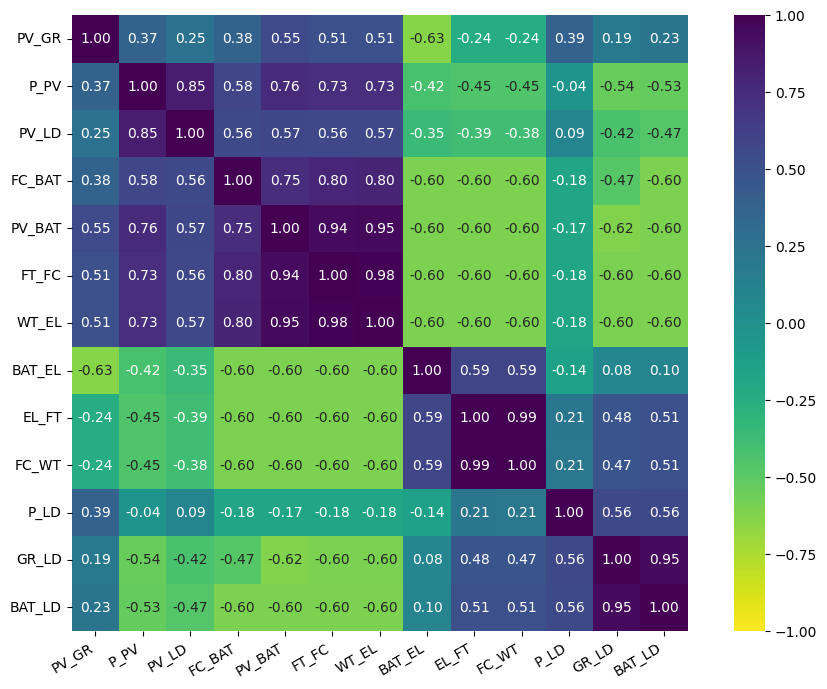

In [16]:
cor_feat, cor_mat = correlation(df, save=True)

In [17]:
cor_feat

{'BAT_LD', 'FC_BAT', 'FC_WT', 'FT_FC', 'PV_BAT', 'PV_LD', 'WT_EL'}

In [18]:
cor_mat

,P_LD,P_PV,PV_GR,PV_LD,GR_LD,PV_BAT,BAT_LD,FC_BAT,BAT_EL,EL_FT,FT_FC,FC_WT,WT_EL
P_LD,1.000000,-0.036244,0.390466,0.092410,0.563930,-0.173781,0.562047,-0.177864,-0.138071,0.213589,-0.180049,0.210613,-0.177896
P_PV,-0.036244,1.000000,0.367816,0.848893,-0.535849,0.760343,-0.529173,0.584709,-0.417912,-0.448963,0.727351,-0.448471,0.729880
PV_GR,0.390466,0.367816,1.000000,0.249110,0.191856,0.550158,0.231510,0.375031,-0.632878,-0.239035,0.510736,-0.242112,0.512342
PV_LD,0.092410,0.848893,0.249110,1.000000,-0.423723,0.573778,-0.465371,0.559441,-0.354635,-0.385377,0.563618,-0.384893,0.566262
GR_LD,0.563930,-0.535849,0.191856,-0.423723,1.000000,-0.623634,0.946491,-0.471413,0.082207,0.476443,-0.599364,0.473297,-0.597812
PV_BAT,-0.173781,0.760343,0.550158,0.573778,-0.623634,1.000000,-0.602105,0.747227,-0.602204,-0.602529,0.944331,-0.602470,0.946665
BAT_LD,0.562047,-0.529173,0.231510,-0.465371,0.946491,-0.602105,1.000000,-0.602866,0.101172,0.511174,-0.602866,0.507900,-0.602872
FC_BAT,-0.177864,0.584709,0.375031,0.559441,-0.471413,0.747227,-0.602866,1.000000,-0.602964,-0.603290,0.796629,-0.603231,0.798846
BAT_EL,-0.138071,-0.417912,-0.632878,-0.354635,0.082207,-0.602204,0.101172,-0.602964,1.000000,0.588764,-0.602965,0.591718,-0.602971
EL_FT,0.213589,-0.448963,-0.239035,-0.385377,0.476443,-0.602529,0.511174,-0.603290,0.588764,1.000000,-0.603290,0.993304,-0.603296


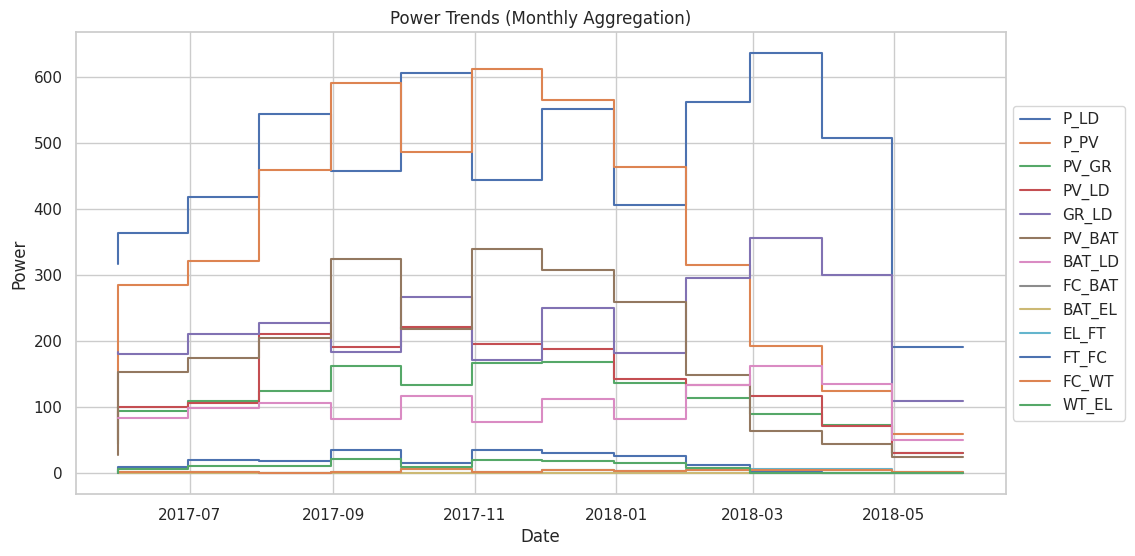

In [19]:
plot_power_trends(df = df, interval = Interval.MONTHLY.value, plot_names = None, x_label = 'Date', y_label = 'Power')

**Impression on LD**: In general, Load consumes more energy from GR than other options. GR contributes to the power requirements by almost half in total.

In [ ]:
sum_col1 = df[DF_Columns.PV_LD.value].sum()
sum_col2 = df[DF_Columns.GR_LD.value].sum()
sum_col3 = df[DF_Columns.BAT_LD.value].sum()
total_sum = df[DF_Columns.LOAD.value].sum()

contribution_col1 = sum_col1 / total_sum
contribution_col2 = sum_col2 / total_sum
contribution_col3 = sum_col3 / total_sum

print("Contribution of PV:", contribution_col1)
print("Contribution of GR:", contribution_col2)
print("Contribution of BAT:", contribution_col3)

In [ ]:
plot_power_trends(df = df, interval = Interval.WEEKLY.value, plot_names = [DF_Columns.LOAD, DF_Columns.PV_LD, DF_Columns.GR_LD, DF_Columns.BAT_LD], x_label = 'Date', y_label = 'Power')

In [ ]:
plot_power_trends(df = df, interval = Interval.WEEKLY.value, plot_names = [DF_Columns.GR_LD], x_label = 'Date', y_label = 'Power')

In [ ]:
plot_power_trends(df = df, interval = Interval.WEEKLY.value, plot_names = [DF_Columns.PV_LD], x_label = 'Date', y_label = 'Power')

In [ ]:
plot_power_trends(df = df, interval = Interval.WEEKLY.value, plot_names = [DF_Columns.BAT_LD], x_label = 'Date', y_label = 'Power')

**Impression on PV**: The half of the produced power by PV is consumed by BAT.

In [ ]:
sum_col1 = df[DF_Columns.PV_GR.value].sum()
sum_col2 = df[DF_Columns.PV_LD.value].sum()
sum_col3 = df[DF_Columns.PV_BAT.value].sum()
total_sum = df[DF_Columns.PV.value].sum()

consumption_col1 = sum_col1 / total_sum
consumption_col2 = sum_col2 / total_sum
consumption_col3 = sum_col3 / total_sum

print("Consumption of GR:", consumption_col1)
print("Consumption of LD:", consumption_col2)
print("Consumption of BAT:", consumption_col3)

In [ ]:
plot_power_trends(df = df, interval = Interval.WEEKLY.value, plot_names = [DF_Columns.PV, DF_Columns.PV_GR, DF_Columns.PV_LD, DF_Columns.PV_BAT], x_label = 'Date', y_label = 'Power')

**Impression on EL**: BAT sends a negligible amount of power to EL to ignite the process. On the other hand, the main power source of EL is WT.

In [ ]:
plot_power_trends(df = df, interval = Interval.WEEKLY.value, plot_names = [DF_Columns.BAT_EL], x_label = 'Date', y_label = 'Power')

In [ ]:
plot_power_trends(df = df, interval = Interval.WEEKLY.value, plot_names = [DF_Columns.WT_EL], x_label = 'Date', y_label = 'Power')

**MODELS**

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, GRU, SimpleRNN, Bidirectional, Dropout, Activation
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import *
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
import math
import tensorflow as tf

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training and Validation Loss')
  plt.legend()
  plt.show()

In [ ]:
def create_sequences(data, seq_length):
  X, y = [], []
  for i in range(len(data) - seq_length + 1):
    X.append(data.iloc[i:(i + seq_length), :].values)
    y.append(data.iloc[i + seq_length - 1, :].values)
  return np.array(X), np.array(y)

In [ ]:
def exponential_decay_scheduler(epoch, lr):
  initial_lr = 0.1
  k = 0.1
  new_lr = initial_lr * math.exp(-k * epoch)
  return new_lr

In [ ]:
def time_based_decay_scheduler(epoch, lr):
  initial_lr = 0.1
  decay_rate = 0.1
  new_lr = initial_lr / (1 + decay_rate * epoch)
  return new_lr

In [ ]:
def step_decay_scheduler(epoch, lr):
  initial_lr = 0.1
  drop = 0.5
  epochs_drop = 10
  new_lr = initial_lr * (drop ** (epoch // epochs_drop))
  return new_lr

In [ ]:
def min_max_scale(df):
  scaled_data = {}
  scalers = {}
  for col in df.columns:
    scaler = MinMaxScaler()
    scaled_data[col] = scaler.fit_transform(df[col].values.reshape(-1, 1)).flatten()
    scalers[col] = scaler
  scaled_df = pd.DataFrame(scaled_data, index=df.index)
  return scaled_df, scalers

In [ ]:
def inverse_min_max_scale(scaled_df, scalers):
  inverse_scaled_data = {}
  for col in scaled_df.columns:
    scaler = scalers[col]
    inverse_scaled_data[col] = scaler.inverse_transform(scaled_df[col].values.reshape(-1, 1)).flatten()
  inverse_scaled_df = pd.DataFrame(inverse_scaled_data, index=scaled_df.index)
  return inverse_scaled_df

In [ ]:
df_dropped = df.drop(['Load_kWh', 'PV_kWh', 'P6 (FC_BAT)', 'P7 (BAT_EL)', 'P8 (EL_FT)', 'P9 (FT_FC)', 'P10 (FC_WT)', 'P11 (WT_EL)'], axis=1)

In [ ]:
cor_feat2, cor_mat2 = correlation(df_dropped)

In [ ]:
df_scaled, scalers = min_max_scale(df_dropped)

In [ ]:
seq_length = 24
X, y = create_sequences(df_scaled, seq_length)

In [ ]:
train_size = int(len(df_scaled) * 0.64)
val_size = int(len(df_scaled) * 0.16)
test_size = len(df_scaled) - train_size - val_size

In [ ]:
train_data = df_scaled.iloc[:train_size]
val_data = df_scaled.iloc[train_size:train_size + val_size]
test_data = df_scaled.iloc[train_size + val_size:]

In [ ]:
seq_length = 24
X_train, y_train = create_sequences(train_data, seq_length)
X_val, y_val = create_sequences(val_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)
exp_decay = LearningRateScheduler(exponential_decay_scheduler)
step_decay = LearningRateScheduler(step_decay_scheduler)
tb_decay = LearningRateScheduler(time_based_decay_scheduler)
input_shape = (X_train.shape[1], X_train.shape[2])
epochs = 20
batch_size = 7
neurons = X_train.shape[2]
units = X_train.shape[2] * 10
optimizer = 'rmsprop'
metrics = ["mean_squared_error", "mean_absolute_percentage_error", "mean_squared_logarithmic_error", "logcosh"]
model_name = 'SimpleRNN' #'LSTM' or 'SimpleRNN' or 'GRU'
use_bidirectional = False

In [ ]:
bidire = Bidirectional if use_bidirectional else lambda x: x
layer_class = getattr(tf.keras.layers, model_name)

In [ ]:
model = Sequential()

#model.add(bidire(layer_class(units=units, input_shape=input_shape)))
model.add(bidire(layer_class(units=units, return_sequences=True, input_shape=input_shape)))
model.add(bidire(layer_class(units=units, return_sequences=True)))
model.add(bidire(layer_class(units=units)))

model.add(Dense(neurons))
model.add(Activation('relu'))

if use_bidirectional:
  model.build(input_shape=X_train.shape)

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=metrics)

In [ ]:
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_val, y_val), callbacks=[])

In [ ]:
plot_loss(history)

In [ ]:
loss = model.evaluate(X_test, y_test)
print('Test Loss:', loss)

In [ ]:
test_predict = model.predict(X_test)

In [ ]:
#Metrics
  #R2 - close to 1
r2_value = r2_score(y_test, test_predict)
print("R2 = " + str(r2_value))

  #MSE - lower values
mse = mean_squared_error(y_test, test_predict, squared = True)
print("MSE = " + str(mse))

  #RMSE - lower values
rmse = mean_squared_error(y_test, test_predict, squared = False)
print("RMSE = " + str(rmse))

  #MAE - lower values
mae = mean_absolute_error(y_test, test_predict)
print("MAE = " + str(mae))

  #Explained Variance Score - close to 1
evs = explained_variance_score(y_test, test_predict)
print("EVS = " + str(evs))

  #Mean Pinball Loss - lower values
mpl = mean_pinball_loss(y_test, test_predict)
print("MPL = " + str(mpl))

In [ ]:
predicted_df = inverse_min_max_scale(pd.DataFrame(test_predict, index=df.index[len(train_data) + len(val_data) + seq_length - 1:], columns=df_scaled.columns), scalers)
actual_df = inverse_min_max_scale(pd.DataFrame(y_test, index=df.index[len(train_data) + len(val_data) + seq_length - 1:], columns=df_scaled.columns), scalers)

In [ ]:
test_mae = mean_absolute_error(predicted_df, actual_df)
test_mse = mean_squared_error(predicted_df, actual_df)
print(test_mae)
print(test_mse)

In [ ]:
for column in actual_df.columns:
  plt.figure(figsize=(12, 6))
  plt.plot(actual_df.index, actual_df[column], label='Actual')
  plt.plot(predicted_df.index, predicted_df[column], label='Predicted')
  plt.xlabel('Timestamp')
  plt.ylabel('Value')
  plt.title(f'Actual vs Predicted for {column}')
  plt.legend()
  plt.show()

In [ ]:
future_steps = 24 * 7
future_X = X_test[-1]
future_predictions = []

for i in range(future_steps):
  future_X_reshaped = future_X.reshape(1, seq_length, future_X.shape[1])
  future_pred = model.predict(future_X_reshaped, verbose=0)
  future_predictions.append(future_pred[0])
  future_X = np.append(future_X[1:], future_pred, axis=0)

In [ ]:
future_predictions_df = inverse_min_max_scale(pd.DataFrame(future_predictions, index=pd.date_range(start=df.index[-1], periods=future_steps, freq='H'), columns=df_scaled.columns), scalers)

In [ ]:
for column_name in df_scaled.columns:
  plt.figure(figsize=(10, 4))
  plt.step(df.index[-seq_length:], df[column_name].values[-seq_length:], label='Last Sequence - Original Data')
  plt.step(future_predictions_df.index, future_predictions_df[column_name], label='Forecast')
  plt.xlabel('Timestamp')
  plt.ylabel('Value')
  plt.title('Forecasting of ' + column_name)
  plt.legend()
  plt.show()